March 21, 2025

Based on 100-300.

In [1]:
# Amount of time after heat is turned off before the main cooling segment starts
delay_time = 120
# Amount of time before sunrise to stop the main cooling segment
before_sunrise_delta_minutes = 0 #30

# Number of minutes to resample
# This value 
resample_minutes = 5 #3 #5 #10 #15

smoothed_window = 60 #60  # 1 hour window for smoothing

In [2]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
# from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [3]:
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

# Define Livermore, CA location
livermore = LocationInfo('Livermore', 'California', 'US', 37.6819, -121.7680)

# Function to get sunrise time for a given date
def get_sunrise(date):
    s = sun(livermore.observer, date=date)
    return s['sunrise'].astimezone(ZoneInfo('America/Los_Angeles')).replace(tzinfo=None)

In [4]:
def preprocess_temperature_file(df: DataFrame) -> DataFrame:
    # Rename the temperature columns to something simpler
    df = df.rename(columns={
        'Temperature Sensor 1._temperature._tcp.local.': 'temp1',
        'Temperature Sensor 2._temperature._tcp.local.': 'temp2'
    })

    # Convert timestamp string to datetime
    df['timestamp'] = pd.to_datetime(df['Timestamp'])

    # Drop the original Timestamp column
    df = df.drop('Timestamp', axis=1)

    # Replace 'ERROR' with NaN (Not a Number)
    df['temp1'] = pd.to_numeric(df['temp1'], errors='coerce')
    df['temp2'] = pd.to_numeric(df['temp2'], errors='coerce')

    # Display the first few rows and basic statistics
    print("First few rows of the parsed data:")
    print(df.head())
    print("\nBasic statistics:")
    print(df.describe())

    return df

In [ ]:
# Read the CSV file
filename_old_door = 'temperature_logB_12.csv'
filename_new_door = 'temperature_logC_2025-03-12.csv'
dfo = pd.read_csv(filename_old_door)
dfn = pd.read_csv(filename_new_door)

# ---
# Filter New Door data after the specified timestamp
cutoff_time = '2025-02-27 19:48:04'
#cutoff_time = pd.to_datetime(cutoff_time)
dfn = dfn[dfn['Timestamp'] >= cutoff_time]
print(f"Filtered data to entries after {cutoff_time}")
# ---

print("Old door temperature file:\n")
dfo = preprocess_temperature_file(dfo)
print("\n" + "_"*80 + "\n")
print("New door temperature file:\n")
dfn = preprocess_temperature_file(dfn)

"""
window_size = 5 #11
# This is an experiment in a different windowing method.  It basically works, but has its own sensitivity issues.
# Gaussian-weighted window
dfn_smoothed1 = dfn.set_index('timestamp')['temp1'].rolling(window=window_size, center=True, win_type='gaussian').mean(std=2)
dfn_smoothed2 = dfn.set_index('timestamp')['temp2'].rolling(window=window_size, center=True, win_type='gaussian').mean(std=2)

dfo_smoothed1 = dfo.set_index('timestamp')['temp1'].rolling(window=window_size, center=True, win_type='gaussian').mean(std=2)
dfo_smoothed2 = dfo.set_index('timestamp')['temp2'].rolling(window=window_size, center=True, win_type='gaussian').mean(std=2)

# Or using pandas ewm (exponentially weighted moving average)
#dfn_smoothed1 = dfn.set_index('timestamp')['temp1'].ewm(span=window_size).mean()

# Using first() - takes the first value in each bin
#dfn_resampled1 = dfn_smoothed1.resample(f'{resample_minutes}min').first()

# OR using asfreq() - takes the value at exact timestamp
#dfn_resampled1 = dfn_smoothed1.resample(f'{resample_minutes}min').asfreq()
#dfn_resampled2 = dfn_smoothed2.resample(f'{resample_minutes}min').asfreq()

#dfo_resampled1 = dfo_smoothed1.resample(f'{resample_minutes}min').asfreq()
#dfo_resampled2 = dfo_smoothed2.resample(f'{resample_minutes}min').asfreq()

dfn_resampled1 = (dfn_smoothed1
                  .resample(f'{resample_minutes}min')
                  .interpolate(method='linear').dropna())
dfn_resampled2 = (dfn_smoothed2
                  .resample(f'{resample_minutes}min')
                  .interpolate(method='linear').dropna())

dfo_resampled1 = (dfo_smoothed1
                  .resample(f'{resample_minutes}min')
                  .interpolate(method='linear').dropna())
dfo_resampled2 = (dfo_smoothed2
                  .resample(f'{resample_minutes}min')
                  .interpolate(method='linear').dropna())

"""

# Resample data for both sensors
dfn_resampled1 = dfn.set_index('timestamp').resample(f'{resample_minutes}min')['temp1'].mean()
dfn_resampled2 = dfn.set_index('timestamp').resample(f'{resample_minutes}min')['temp2'].mean()

dfo_resampled1 = dfo.set_index('timestamp').resample(f'{resample_minutes}min')['temp1'].mean()
dfo_resampled2 = dfo.set_index('timestamp').resample(f'{resample_minutes}min')['temp2'].mean()

Filtered data to entries after 2025-02-27 19:48:04
Old door temperature file:

First few rows of the parsed data:
   temp1  temp2           timestamp
0  21.06  11.81 2025-02-13 20:42:55
1  21.19  11.75 2025-02-13 20:43:27
2  21.12  11.94 2025-02-13 20:44:00
3  21.12  11.94 2025-02-13 20:44:31
4  21.06  11.75 2025-02-13 20:45:03

Basic statistics:
              temp1         temp2                      timestamp
count  37292.000000  37812.000000                          37815
mean      19.319578     12.635908  2025-02-20 22:23:28.933412608
min       15.690000      3.810000            2025-02-13 20:42:55
25%       18.560000      9.560000            2025-02-17 11:43:30
50%       19.560000     12.120000            2025-02-20 22:30:20
75%       20.310000     15.310000     2025-02-24 09:13:34.500000
max       21.250000     24.620000            2025-02-27 19:48:04
std        1.201263      4.128757                            NaN

_________________________________________________________________

In [6]:
def find_cooling_segments(df_resampled1, df_resampled2, N_cooling=10, N_warming=4):
    """
    Find the region of data defined such that it begins where the smoothed df_resampled1 (indoors) temperature decays (specifically, does not increase) for 10 consecutive data points and ends just prior to where that temperature increases 4 consecutive times.
    
    Args:
        df_resampled1: pandas Series of indoor temperature data
        df_resampled2: pandas Series of outdoor temperature data
        N_cooling: number of consecutive data points where temperature does not increase
        N_warming: number of consecutive data points where temperature increases
    Returns:
        segments: list of dictionaries, each containing the start and end times of a cooling segment
    """
    # Calculate temperature differences
    temp_diff = df_resampled1.diff()
    
    # Find sequences where temperature is not increasing (diff <= 0)
    not_increasing = temp_diff <= 0
    
    segments = []
    i = 0
    
    while i < len(not_increasing) - N_cooling:
        # Look for cooling sequence start
        run_length = 0
        while i < len(not_increasing) - N_cooling:
            if not_increasing.iloc[i]:
                run_length += 1
                if run_length == N_cooling:
                    start_idx = i - N_cooling + 1  # Go back to start of sequence
                    break
            else:
                run_length = 0
            i += 1
            
        if i >= len(not_increasing) - N_cooling:
            break
            
        # Find end of sequence (N_warming consecutive increasing points)
        end_idx = start_idx + N_cooling
        while end_idx < len(temp_diff) - N_warming:
            if all(temp_diff.iloc[end_idx:end_idx + N_warming] > 0):
                break
            end_idx += 1
            
        # Get the timestamps for these indices
        start_time = not_increasing.index[start_idx]
        end_time = not_increasing.index[end_idx]
        
        # Select data for this time range
        mask = (df_resampled1.index >= start_time) & (df_resampled1.index < end_time)
        segment = {
            'start_time': start_time,
            'end_time': end_time,
            'temp1': df_resampled1[mask],
            'temp2': df_resampled2[mask]
        }
        segments.append(segment)
        
        # Move index past this segment
        i = end_idx + 1
    
    return segments

In [7]:
def add_segment_times(segment, delta_minutes: int = 60, before_sunrise_delta_minutes: int = 30):
    """
    Adds delay_time and sunrise_time to a segment dictionary.
    
    Args:
        segment: dictionary containing start_time and end_time
        delta_minutes: number of minutes to add to start_time for delay_time
        before_sunrise_delta_minutes: number of minutes to subtract from sunrise_time
    """
    # Convert pandas Timestamp to datetime if necessary and add delay time
    start_time = segment['start_time'].to_pydatetime() if hasattr(segment['start_time'], 'to_pydatetime') else segment['start_time']
    end_time = segment['end_time'].to_pydatetime() if hasattr(segment['end_time'], 'to_pydatetime') else segment['end_time']
    
    segment['delay_time'] = start_time + timedelta(minutes=delta_minutes)
    
    # Get the last date in the segment and find its sunrise
    last_date = end_time.date()
    segment['sunrise_time'] = get_sunrise(last_date) - timedelta(minutes=before_sunrise_delta_minutes)
    
    return segment


In [8]:
def is_sunrise_between(segment):
    """Check if sunrise_time falls between start_time and end_time for a segment"""
    start = segment['start_time'].to_pydatetime() if hasattr(segment['start_time'], 'to_pydatetime') else segment['start_time']
    end = segment['end_time'].to_pydatetime() if hasattr(segment['end_time'], 'to_pydatetime') else segment['end_time']
    sunrise = segment['sunrise_time']
    
    return start <= sunrise <= end

In [9]:
segments_new_door = find_cooling_segments(dfn_resampled1, dfn_resampled2) #dfn['temp1'], dfn['temp2'])
segments_old_door = find_cooling_segments(dfo_resampled1, dfo_resampled2) #dfo['temp1'], dfo['temp2'])

# Apply to all segments
segments_new_door = [add_segment_times(segment, delay_time, before_sunrise_delta_minutes) for segment in segments_new_door]
segments_old_door = [add_segment_times(segment, delay_time, before_sunrise_delta_minutes) for segment in segments_old_door]

# Remove segments that don't have a sunrise between start_time and end_time (presumably spurious times of day)
segments_new_door = [segment for segment in segments_new_door if is_sunrise_between(segment)]
segments_old_door = [segment for segment in segments_old_door if is_sunrise_between(segment)]

In [10]:
from scipy.optimize import curve_fit

def linear_func(x, m, b):
    return m*x + b

def linear_func_0_y(x, m):
    """y intercept = 0"""
    return m*x

def plot_linear_fit(segments, sup_title):
    # Collect all valid data points from the main periods (between delay and sunrise)
    x_all = []
    y_all = []

    for segment in segments:
        # Get temperature difference data
        temp_diff = segment['temp1'] - segment['temp2']
        
        # Calculate cooling rate
        regular_time = pd.date_range(start=segment['temp1'].index[0], 
                                end=segment['temp1'].index[-1],
                                freq='1min')
        
        temp_interp = pd.Series(index=regular_time, 
                            data=np.interp(mdates.date2num(regular_time),
                                            mdates.date2num(segment['temp1'].index),
                                            segment['temp1'].values))
        
        # Calculate derivative and smooth it
        window = smoothed_window #60  # 1 hour window for smoothing
        dt = 1/60  # time step in hours
        dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
        dT_dt_smooth = pd.Series(index=regular_time,
                                data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
        
        # Get x and y data
        x_data = -dT_dt_smooth
        y_data = pd.Series(index=regular_time,
                        data=np.interp(mdates.date2num(regular_time),
                                        mdates.date2num(temp_diff.index),
                                        temp_diff.values))
        
        # Create mask for main period
        mask_main = (regular_time >= segment['delay_time']) & (regular_time < segment['sunrise_time'])
        
        # Remove any NaN values from main section
        valid_data = ~np.isnan(x_data[mask_main]) & ~np.isnan(y_data[mask_main])
        if len(valid_data) > 0:
            x_section = x_data[mask_main][valid_data]
            y_section = y_data[mask_main][valid_data]
            
            x_all.extend(x_section)
            y_all.extend(y_section)

    # Convert to numpy arrays
    x_all = np.array(x_all)
    y_all = np.array(y_all)

    # Fit the data
    popt, pcov = curve_fit(linear_func, x_all, y_all)
    A, b = popt
    A_err, b_err = np.sqrt(np.diag(pcov))

    popt0, pcov0 = curve_fit(linear_func_0_y, x_all, y_all)
    A0, = popt0
    A0_err, = np.sqrt(np.diag(pcov0))

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), height_ratios=[2, 1])

    # Plot data and fit in top subplot
    colors = plt.cm.tab10(np.linspace(0, 1, len(segments)))

    for i, segment in enumerate(segments):
        # Get temperature difference data
        temp_diff = segment['temp1'] - segment['temp2']
        
        # Calculate cooling rate
        regular_time = pd.date_range(start=segment['temp1'].index[0], 
                                end=segment['temp1'].index[-1],
                                freq='1min')
        
        temp_interp = pd.Series(index=regular_time, 
                            data=np.interp(mdates.date2num(regular_time),
                                            mdates.date2num(segment['temp1'].index),
                                            segment['temp1'].values))
        
        # Calculate derivative and smooth it
        window = smoothed_window #60  # 1 hour window for smoothing
        dt = 1/60  # time step in hours
        dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
        dT_dt_smooth = pd.Series(index=regular_time,
                                data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
        
        # Get x and y data
        x_data = -dT_dt_smooth
        y_data = pd.Series(index=regular_time,
                        data=np.interp(mdates.date2num(regular_time),
                                        mdates.date2num(temp_diff.index),
                                        temp_diff.values))
        
        # Create masks for different time periods
        mask_before_delay = regular_time < segment['delay_time']
        mask_main = (regular_time >= segment['delay_time']) & (regular_time < segment['sunrise_time'])
        mask_after_sunrise = regular_time >= segment['sunrise_time']
        
        # Plot each section with appropriate style
        for mask, style in [(mask_before_delay, '--'), (mask_main, '-'), (mask_after_sunrise, '--')]:
            valid_data = ~np.isnan(x_data[mask]) & ~np.isnan(y_data[mask])
            if len(valid_data) > 0:
                x_section = x_data[mask][valid_data]
                y_section = y_data[mask][valid_data]
                
                if len(x_section) > 0:
                    # Plot data
                    ax1.plot(x_section, y_section, f'{style}', color=colors[i], 
                            label=f'Segment {i+1}' if mask is mask_main else "", 
                            alpha=0.7, markersize=3)
                    
                    # Plot residuals for main section only
                    if mask is mask_main:
                        residuals = y_section - linear_func(x_section, A, b)
                        ax2.plot(x_section, residuals, f'{style}', color=colors[i],
                                alpha=0.7, markersize=3)

    # Plot the fit line
    x_fit = np.linspace(min(x_all), max(x_all), 100)
    ax1.plot(x_fit, linear_func(x_fit, A, b), 'k-', label=f'Fit: {A:.3f}x + {b:.3f}')
    ax1.plot(x_fit, linear_func_0_y (x_fit, A0), 'k--', label=f'Fit: {A0:.3f}x')

    # Calculate R-squared
    residuals = y_all - linear_func(x_all, A, b)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_all - np.mean(y_all))**2)
    r_squared = 1 - (ss_res / ss_tot)


    # Calculate R-squared for fit with y intercept = 0
    residuals0 = y_all - linear_func_0_y(x_all, A0)
    ss_res0 = np.sum(residuals0**2)
    # Note that we are not subtracting the mean of y_all from y_all in the denominator
    # because we are fitting with y intercept = 0
    ss_tot0 = np.sum((y_all - 0.0*np.mean(y_all))**2)
    r_squared0 = 1 - (ss_res0 / ss_tot0)

    # Customize plots
    ax1.set_xlabel('Cooling Rate (°C/hour)')
    ax1.set_ylabel('Temperature Difference (°C)')
    ax1.set_title('Temperature Difference vs Cooling Rate\n' +
                f'(excluding first {delay_time} minutes and last {before_sunrise_delta_minutes} minutes before sunrise of each sequence)\n' +
                f'temp_diff = {A:.3f}*cooling_rate + {b:.3f}, R² = {r_squared:.3f}\n'
                f'b=0 fit: temp_diff = {A0:.3f}*cooling_rate, R² = {r_squared0:.3f}')
    ax1.set_ylim(0, 14.2)
    #ax1.set_xlim(0, None)
    ax1.legend(loc='lower right')
    ax1.grid(True)

    ax2.set_xlabel('Cooling Rate (°C/hour)')
    ax2.set_ylabel('Residuals (°C)')
    ax2.set_title('Residuals')
    ax2.grid(True)
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    plt.suptitle(sup_title)
    plt.tight_layout()
    plt.show()

    # Print fit results
    print(f"\nFit Results:")
    print(f"A = {A:.3f} ± {A_err:.3f} °C/(°C/hour)")
    print(f"b = {b:.3f} ± {b_err:.3f} °C")
    print(f"R² = {r_squared:.3f}")


    print(f"\nFit Results for b = 0:")
    print(f"A0 = {A0:.3f} ± {A0_err:.3f} °C/(°C/hour)")
    print(f"R0² = {r_squared0:.3f}")

    return A, b, A0, r_squared, r_squared0

In [11]:
def plot_all_segments(segments, sup_title, A, b):
    fig, axes = plt.subplots(len(segments), 2, figsize=(15, 6*len(segments)))
    if len(segments) == 1:
        axes = [axes]

    for i, (ax1, ax2) in enumerate(axes):
        segment = segments[i]
            
        # Create secondary y-axes
        ax1_f = ax1.twinx()  # Fahrenheit axis
        ax2_rate = ax2.twinx()  # Cooling rate axis
        
        # Plot temperatures on first subplot (keeping original style)
        ax1.plot(segment['temp1'].index, segment['temp1'].values, '-r', 
                linewidth=1.5, label=f'Sensor 1 ({resample_minutes}min avg)')
        ax1.plot(segment['temp2'].index, segment['temp2'].values, '-b', 
                linewidth=1.5, label=f'Sensor 2 ({resample_minutes}min avg)')
        
        # Calculate temperature difference
        temp_diff = segment['temp1'] - segment['temp2']
        
        # Split temp_diff into three periods
        mask_before_delay = temp_diff.index < segment['delay_time']
        mask_main = (temp_diff.index >= segment['delay_time']) & (temp_diff.index < segment['sunrise_time'])
        mask_after_sunrise = temp_diff.index >= segment['sunrise_time']
        
        # Plot temperature difference in three parts
        ax2.plot(temp_diff[mask_before_delay].index, temp_diff[mask_before_delay].values, '--k', 
                linewidth=1.5, label='T1 - T2 (before delay)')
        ax2.plot(temp_diff[mask_main].index, temp_diff[mask_main].values, '-k', 
                linewidth=1.5, label='T1 - T2 (main)')
        ax2.plot(temp_diff[mask_after_sunrise].index, temp_diff[mask_after_sunrise].values, '--k', 
                linewidth=1.5, label='T1 - T2 (after sunrise)')
        
        # Calculate cooling rate
        regular_time = pd.date_range(start=segment['temp1'].index[0], 
                                end=segment['temp1'].index[-1],
                                freq='1min')
        
        temp_interp = pd.Series(index=regular_time, 
                            data=np.interp(mdates.date2num(regular_time),
                                            mdates.date2num(segment['temp1'].index),
                                            segment['temp1'].values))
        
        # Calculate derivative and smooth it
        window = smoothed_window #60  # 1 hour window for smoothing
        dt = 1/60  # time step in hours
        dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
        dT_dt_smooth = pd.Series(index=regular_time,
                                data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
        
        # Split cooling rate into three periods
        mask_before_delay = regular_time < segment['delay_time']
        mask_main = (regular_time >= segment['delay_time']) & (regular_time < segment['sunrise_time'])
        mask_after_sunrise = regular_time >= segment['sunrise_time']
        
        # Plot scaled cooling rate in three parts
        scaled_cooling = A*(-dT_dt_smooth) + b
        ax2.plot(regular_time[mask_before_delay], scaled_cooling[mask_before_delay], '--r', alpha=0.7,
                label='Scaled Cooling Rate (before delay)')
        ax2.plot(regular_time[mask_main], scaled_cooling[mask_main], '-r', alpha=0.7,
                label='Scaled Cooling Rate (main)')
        ax2.plot(regular_time[mask_after_sunrise], scaled_cooling[mask_after_sunrise], '--r', alpha=0.7,
                label='Scaled Cooling Rate (after sunrise)')
        
        # Rest of the plotting code remains the same...
        # [Previous axis formatting, limits, labels, etc.]

        # Find the ranges needed for both datasets
        diff_min = temp_diff.min()
        diff_max = temp_diff.max()
        
        # Set y1 limits to include all temperature difference data
        y1_min = min(0, diff_min)
        y1_max = max(22, diff_max)
        ax2.set_ylim(y1_min, y1_max)
        
        # Calculate corresponding y2 limits using y2 = (y1 - b)/A
        y2_min = (y1_min - b)/A
        y2_max = (y1_max - b)/A
        ax2_rate.set_ylim(y2_min, y2_max)
        
        # Customize the plots
        ax1.set_title(f'Cooling Sequence {i+1}\n'
                    f'Start: {segment["start_time"]}\n'
                    f'End: {segment["end_time"]}')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Temperature (°C)')
        ax1_f.set_ylabel('Temperature (°F)')
        
        # Set up Fahrenheit axis limits
        c_min, c_max = ax1.get_ylim()
        ax1_f.set_ylim((c_min * 9/5 + 32), (c_max * 9/5 + 32))
        
        # Customize the difference/rate plot
        ax2.set_title(f'Temperature Difference and Scaled Cooling Rate\n'
                    f'(A = {A:.3f}, b = {b:.3f})')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Temperature Difference (°C)')
        ax2_rate.set_ylabel('Cooling Rate (°C/hour)', color='r')
        
        # Set up grid for both plots
        for ax in [ax1, ax2]:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            ax.xaxis.set_major_locator(mdates.DayLocator())
            ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
            ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:00'))
            ax.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
            ax.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
            ax.grid(True, axis='y', linestyle='--', alpha=0.3)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        # Color cooling rate ticks red
        ax2_rate.tick_params(axis='y', colors='r')
        
        # Add legends
        ax1.legend(loc='upper left')
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines2, labels2, loc='upper right')

    # Add suptitle to the figure
    plt.suptitle(sup_title, fontsize=16, y=1.0)

    plt.tight_layout()
    plt.show()

---
### New Door:

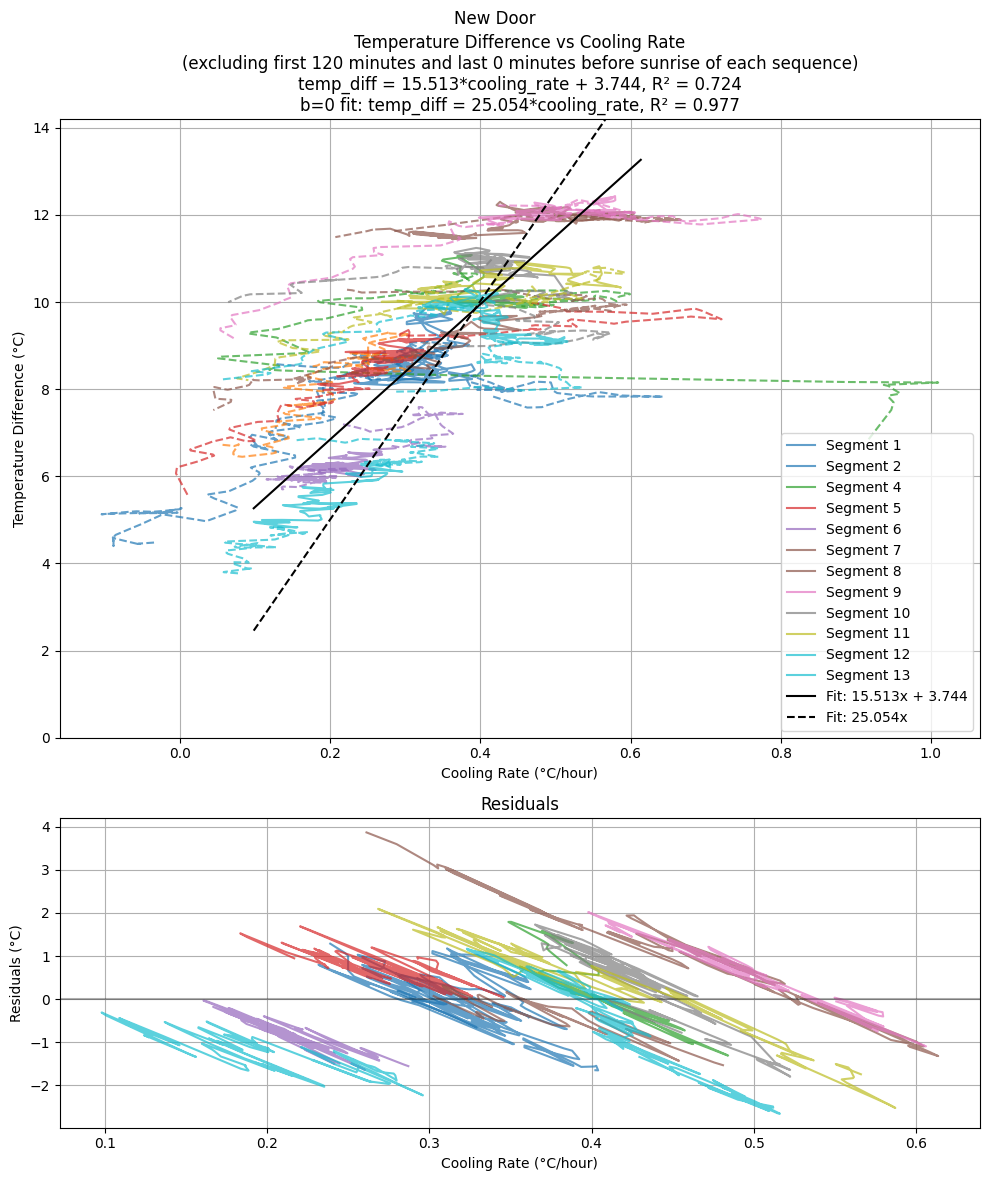


Fit Results:
A = 15.513 ± 0.163 °C/(°C/hour)
b = 3.744 ± 0.062 °C
R² = 0.724

Fit Results for b = 0:
A0 = 25.054 ± 0.066 °C/(°C/hour)
R0² = 0.977


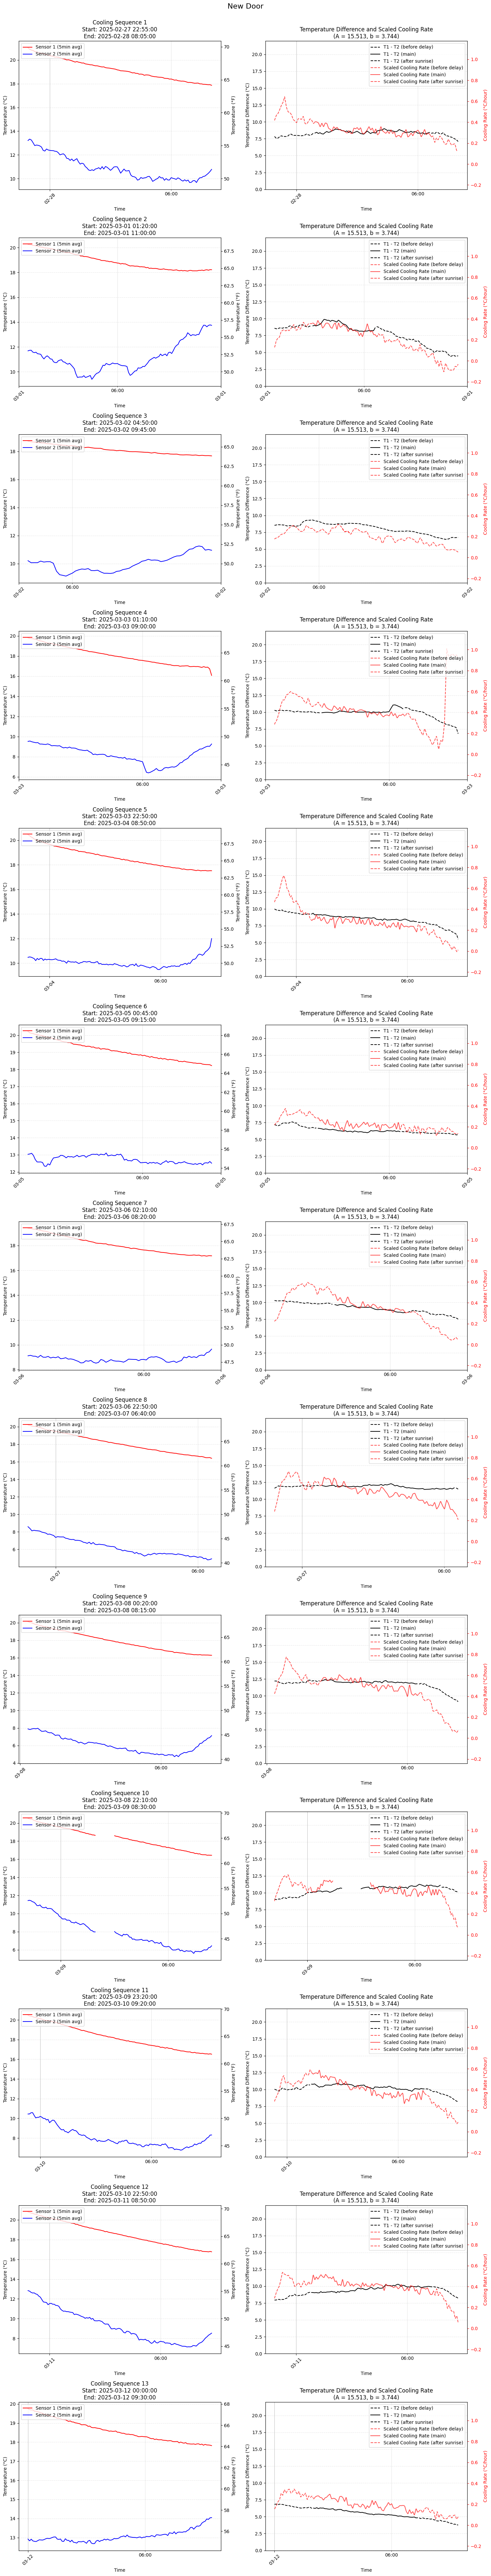

In [12]:
A, b, A0, r_squared, r_squared0 = plot_linear_fit(segments_new_door, "New Door")
plot_all_segments(segments_new_door, "New Door", A, b)

---
### Old Door:

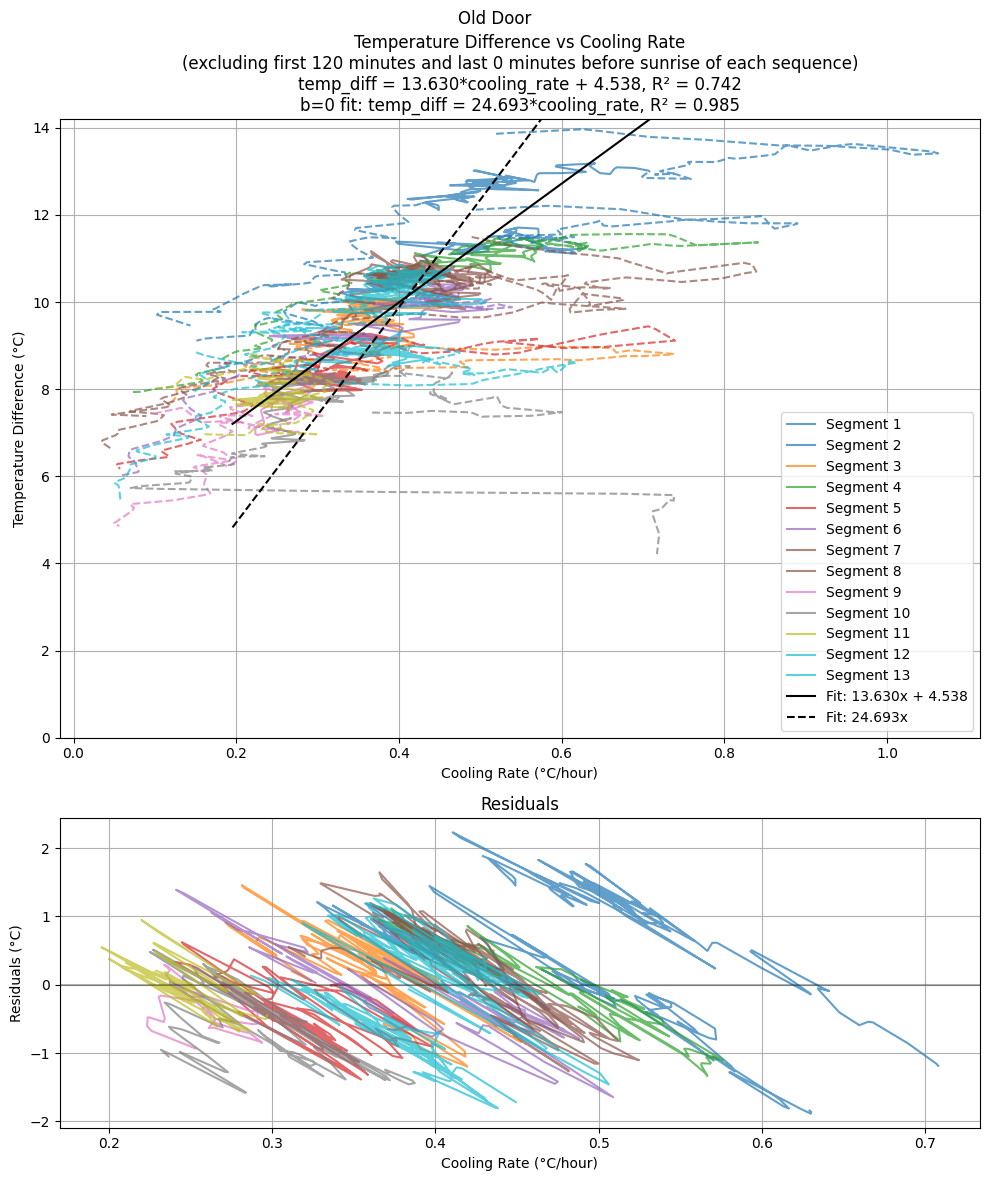


Fit Results:
A = 13.630 ± 0.128 °C/(°C/hour)
b = 4.538 ± 0.051 °C
R² = 0.742

Fit Results for b = 0:
A0 = 24.693 ± 0.049 °C/(°C/hour)
R0² = 0.985


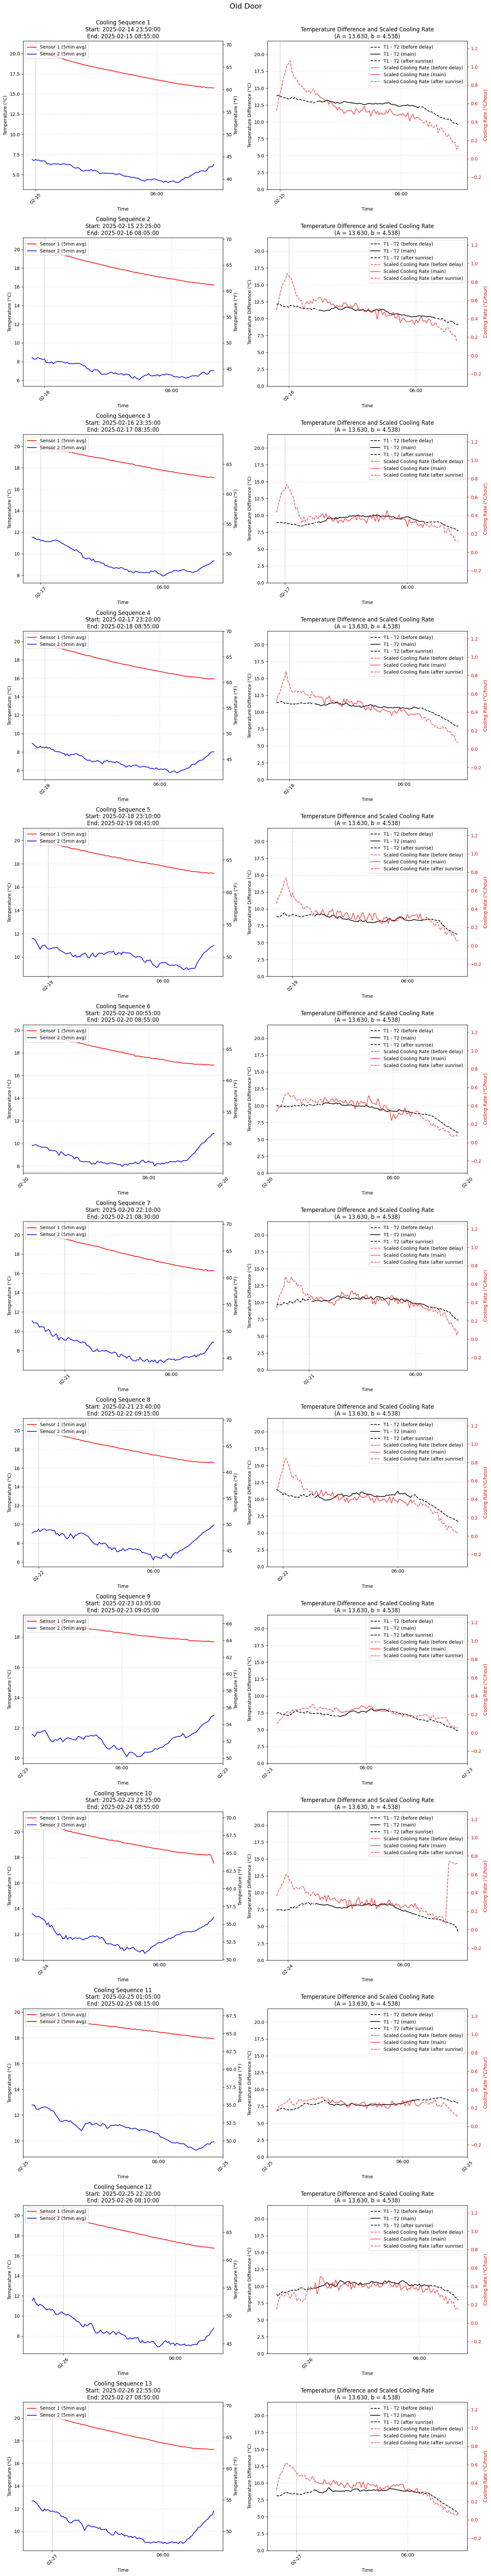

In [13]:
A, b, A0, r_squared, r_squared0 = plot_linear_fit(segments_old_door, "Old Door")
plot_all_segments(segments_old_door, "Old Door", A, b)